# WeatherPy

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats =['retina']

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import pycountry
import seaborn as sns
from scipy.stats import linregress
from matplotlib.pylab import rcParams

sns.set()
plt.rc('lines', linewidth=1)
rcParams['figure.figsize'] = 12,6

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Set the data display options in a float format
pd.options.display.float_format = '{:,.2f}'.format

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print('Number of unique cities', len(cities))

# Creating random dataset for testing
test_cities = np.random.choice(cities, 100)
print('Random array of 100 cities for testing:', [test_cities[i].title() for i in range(len(test_cities))])

Number of unique cities 600
Random array of 100 cities for testing: ['Asau', 'Kapaa', 'Puerto Narino', 'Tuatapere', 'Hammerfest', 'Letterkenny', 'Darnah', 'Biak', 'Lasa', 'Natal', 'Pontianak', 'Ilyich', 'Rincon', 'Saleaula', 'Les Cayes', 'Qui Nhon', 'Husavik', 'Vaitupu', 'Itacoatiara', 'Cabo San Lucas', 'Aflu', 'Faya', 'Muros', 'Buala', 'Vuktyl', 'Bredasdorp', 'Camabatela', 'Ushuaia', 'Blagoveshchenka', 'Umzimvubu', 'Port Augusta', 'Ust-Ilimsk', 'Pontianak', 'Orlik', 'Busselton', 'Yelets', 'Suez', 'Ilyich', 'Arraial Do Cabo', 'Salinas', 'Afgoye', 'Nishihara', 'Tupik', 'Itarema', 'Deer Lake', 'Avera', 'Orapa', 'Beringovskiy', 'Neuquen', 'Aklavik', 'Mar Del Plata', 'Palabuhanratu', 'Hunterville', 'Suez', 'Talcahuano', 'Nizwa', 'Khatanga', 'Siderno', 'Qaqortoq', 'Sao Jose Da Coroa Grande', 'Taree', 'Calabozo', 'Camacari', 'Blackwater', 'Tura', 'Saleaula', 'Guekedou', 'Port Lincoln', 'Jiuquan', 'Nouadhibou', 'Sao Jose Da Coroa Grande', 'Biak', 'Umzimvubu', 'Sibolga', 'Darasun', 'Toliary', 

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [85]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "metric"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="
query_url

'http://api.openweathermap.org/data/2.5/weather?appid=c6f6a86e8a097acc28080af8686cb857&units=metric&q='

In [4]:
# set up lists to hold reponse info
lat = []
lon = []
temp_max = []
humidity = []
cloudiness = []
wind_speed = []
country = []
date = []
found_cities = []
not_found_cities = []

{'cod': '404', 'message': 'city not found'}

In [5]:
# Loop through the list of cities and perform a request for data on each
print('Beginning data retrieval for ', len(cities), ' cities\n')
for city in test_cities:
    response = requests.get(query_url + city).json()
#    print ('Processing request for city:', city)
    try:
        lat.append(response['coord']['lat'])
        lon.append(response['coord']['lon'])
        temp_max.append(response['main']['temp_max'])
        humidity.append(response['main']['humidity'])
        cloudiness.append(response['clouds']['all'])
        wind_speed.append(response['wind']['speed'])
        country.append(response['sys']['country'])
        date.append(response['dt'])
        found_cities.append(city)
    except:
        not_found_cities.append(city)
        pass
    if len(found_cities) % 40 == 0: 
        print('Processing records: found ', len(found_cities),' cities, skipped ', len(not_found_cities), 'cities')
print('\nData retrieval is over\n')
print('Number of skipped cities = ', len(not_found_cities))
print([not_found_cities[i].title() for i in range(len(not_found_cities))])

Beginning data retrieval for  600  cities

Processing records: found  40  cities, skipped  5 cities
Processing records: found  80  cities, skipped  11 cities

Data retrieval is over

Number of skipped cities =  11
['Saleaula', 'Vaitupu', 'Aflu', 'Umzimvubu', 'Afgoye', 'Palabuhanratu', 'Saleaula', 'Guekedou', 'Umzimvubu', 'Toliary', 'Toliary']


In [6]:
# create a data dict from found_cities, lat, lon, temp_max, humidity, cloudiness, wind_speed, country
weather_dict = {
    "City": found_cities,
    "Lat": lat,
    "Lng": lon,
    "Max Temp": temp_max,
    "Humidity": humidity,
    "Cloudiness": cloudiness,
    "Wind Speed": wind_speed,
    "Country Code": country
                }

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [7]:
def country_flag(df):
    if (len(df['Country Code'])==2 and df['Country Code'] in list_alpha_2):
        return pycountry.countries.get(alpha_2=df['Country Code']).name
    else:
        return 'Invalid Code'

In [8]:
# create a data frame from data dict
weather_data = pd.DataFrame(weather_dict)
weather_data['City'] = weather_data['City'].map(str.upper)  
list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
weather_data['Country Name'] = weather_data.apply(country_flag, axis = 1)
weather_data['Date'] = date
weather_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country Code,Country Name,Date
0,ASAU,46.43,26.40,22.22,37,40,5.10,RO,Romania,1594734350
1,KAPAA,22.08,-159.32,25.00,83,40,6.70,US,United States,1594734117
2,PUERTO NARINO,-3.77,-70.38,27.00,88,40,1.00,CO,Colombia,1594734350
3,TUATAPERE,-46.13,167.68,3.89,83,79,1.34,NZ,New Zealand,1594734142
4,HAMMERFEST,70.66,23.68,12.00,66,15,5.10,NO,Norway,1594734351


In [9]:
weather_data.count()

City            89
Lat             89
Lng             89
Max Temp        89
Humidity        89
Cloudiness      89
Wind Speed      89
Country Code    89
Country Name    89
Date            89
dtype: int64

In [10]:
weather_data.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,89.00,89.00,89.00,89.00,89.00,89.00,89.00
mean,18.32,29.03,21.19,68.27,48.69,3.49,"1,594,734,286.92"
std,34.42,86.76,8.96,23.44,36.07,2.00,111.29
min,-54.80,-159.32,-2.00,12.00,0.00,0.27,"1,594,733,948.00"
25%,-8.19,-42.03,13.57,57.00,20.00,1.85,"1,594,734,156.00"
50%,22.93,26.23,24.00,74.00,40.00,3.43,"1,594,734,353.00"
75%,46.62,103.14,27.25,85.00,76.00,5.00,"1,594,734,356.00"
max,71.97,179.32,38.36,100.00,100.00,9.30,"1,594,734,360.00"


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [11]:
high_humidity = weather_data[weather_data['Humidity']>=100]
high_humidity

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country Code,Country Name,Date
26,PORT AUGUSTA,-32.50,137.77,5.56,100,0,2.10,AU,Australia,1594734353


In [12]:
#  Get the indices of cities that have humidity over 100%.
index_label = weather_data.query('Humidity >=100').index.tolist() 
print(index_label, sep=',')

[26]


In [13]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = weather_data.drop(index_label, axis=0, inplace=False)
clean_city_data.shape

(88, 10)

In [14]:
# Export the City_Data into a csv
clean_city_data.to_csv(output_data_file, index=False) 

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [15]:
lat = clean_city_data['Lat']
tem = clean_city_data['Max Temp']
hum = clean_city_data['Humidity']
cld = clean_city_data['Cloudiness']
wnd = clean_city_data['Wind Speed']

## Latitude vs. Temperature Plot

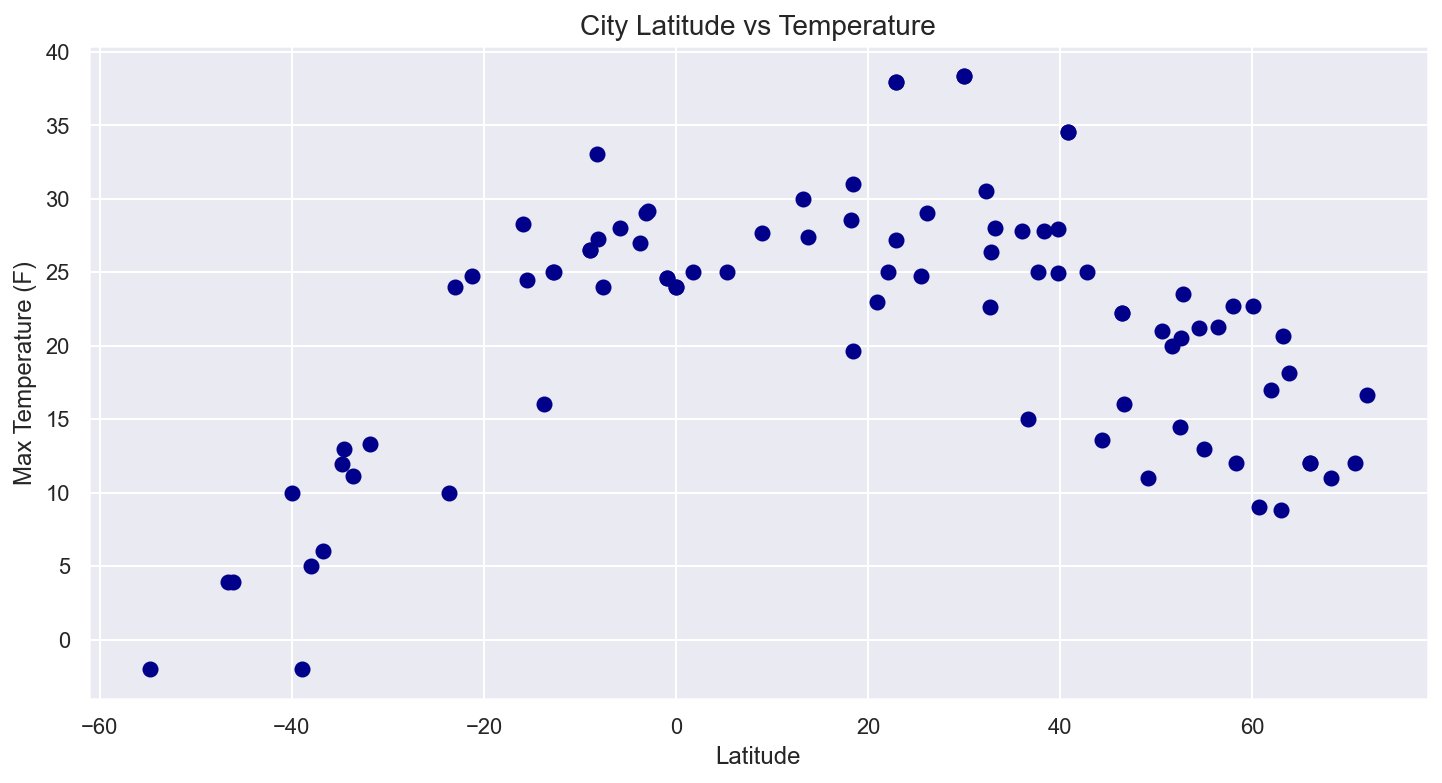

In [16]:
_= plt.plot(lat, tem, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Max Temperature (F)')
_ = plt.title('City Latitude vs Temperature', size=14)

## Latitude vs. Humidity Plot

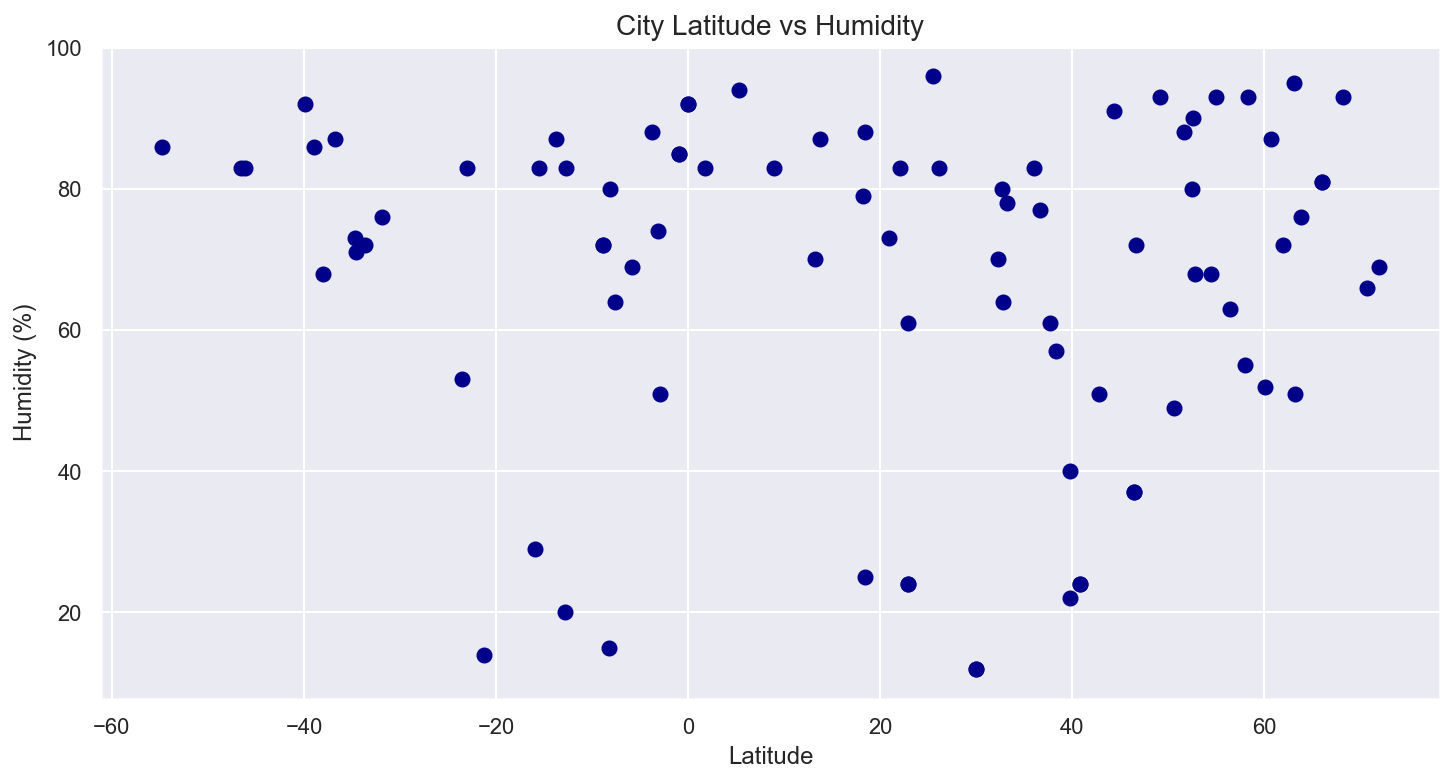

In [17]:
_= plt.plot(lat, hum, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Humidity (%)')
_ = plt.title('City Latitude vs Humidity', size=14)

## Latitude vs. Cloudiness Plot

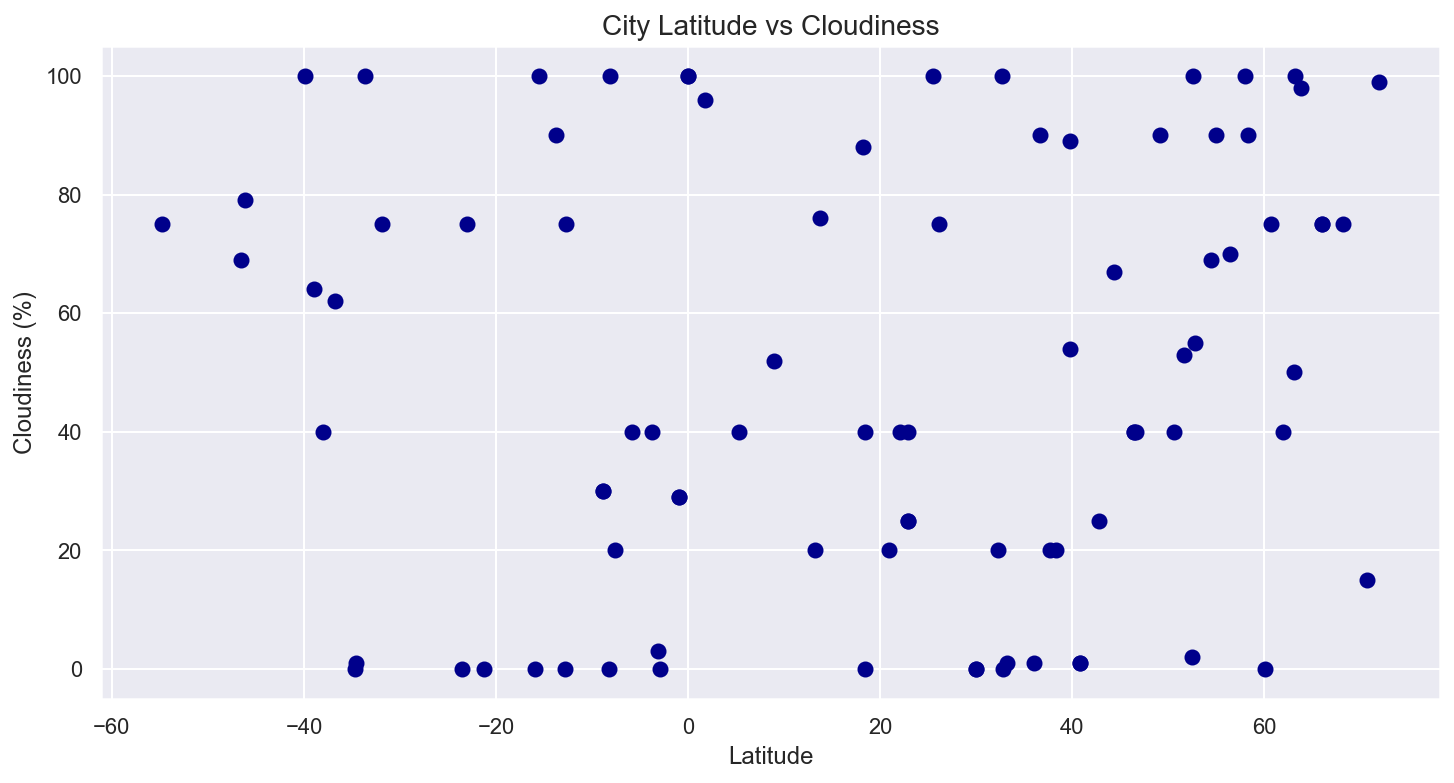

In [18]:
_= plt.plot(lat, cld, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Cloudiness (%)')
_ = plt.title('City Latitude vs Cloudiness', size=14)

## Latitude vs. Wind Speed Plot

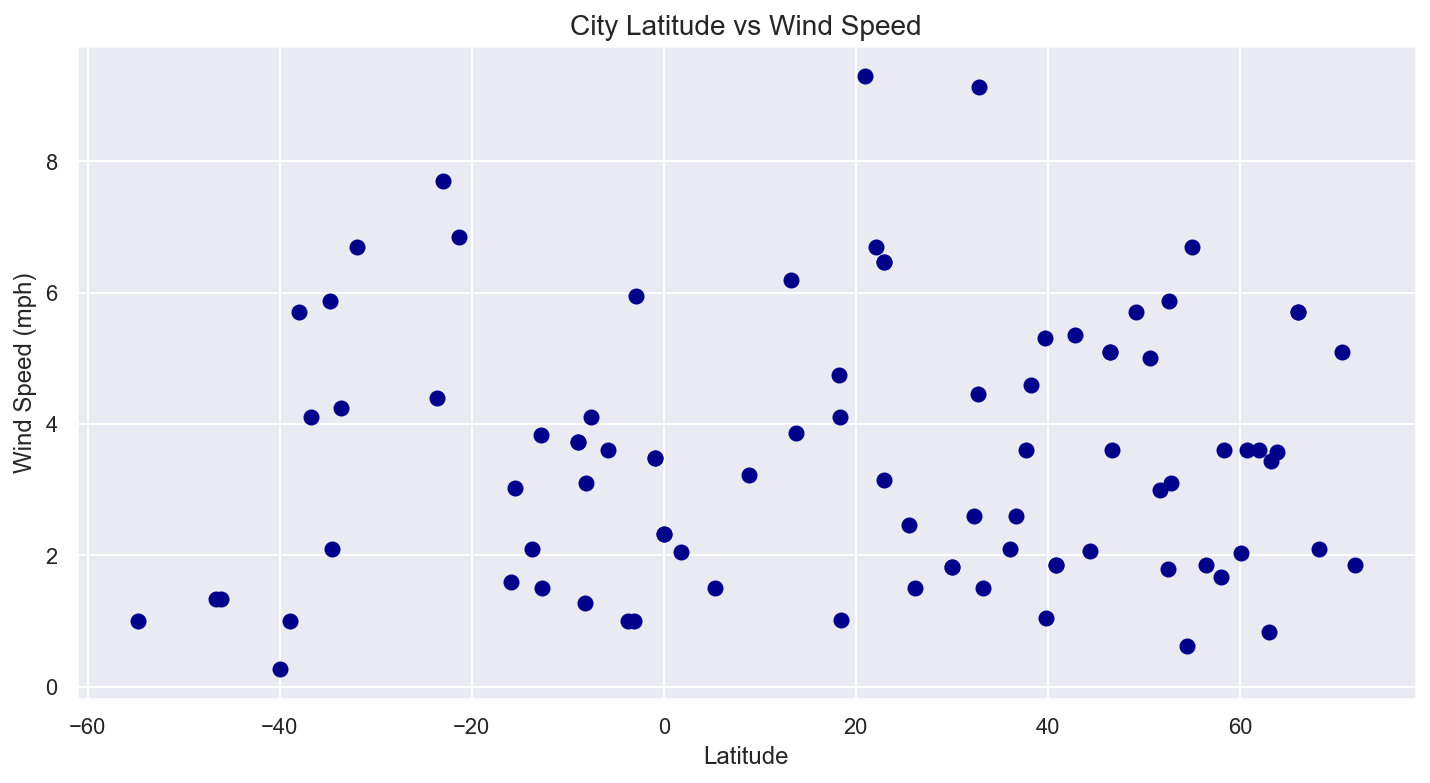

In [19]:
_= plt.plot(lat, wnd, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Wind Speed (mph)')
_ = plt.title('City Latitude vs Wind Speed', size=14)

## Linear Regression

In [55]:
# OPTIONAL: Create a function to create Linear Regression plots


In [54]:
# Create Northern and Southern Hemisphere DataFrames
clean_city_data['Hemisphere'] = (
        np.select(
        condlist=[clean_city_data['Lat'] >= 0, clean_city_data['Lat'] < 0], 
        choicelist=['Northen', 'Southern'] 
       ))
clean_city_data

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country Code,Country Name,Date,Hemisphere
0,ASAU,46.43,26.40,22.22,37,40,5.10,RO,Romania,1594734350,Northen
1,KAPAA,22.08,-159.32,25.00,83,40,6.70,US,United States,1594734117,Northen
2,PUERTO NARINO,-3.77,-70.38,27.00,88,40,1.00,CO,Colombia,1594734350,Southern
3,TUATAPERE,-46.13,167.68,3.89,83,79,1.34,NZ,New Zealand,1594734142,Southern
4,HAMMERFEST,70.66,23.68,12.00,66,15,5.10,NO,Norway,1594734351,Northen
...,...,...,...,...,...,...,...,...,...,...,...
84,GORNOPRAVDINSK,60.05,69.90,22.70,52,0,2.03,RU,Russian Federation,1594734359,Northen
85,IGRIM,63.19,64.42,20.67,51,100,3.43,RU,Russian Federation,1594734359,Northen
86,RIVNE,50.62,26.23,21.00,49,40,5.00,UA,Ukraine,1594734360,Northen
87,ASAU,46.43,26.40,22.22,37,40,5.10,RO,Romania,1594734350,Northen


                        Data exploration (Northern vs Southern Hemisphere)


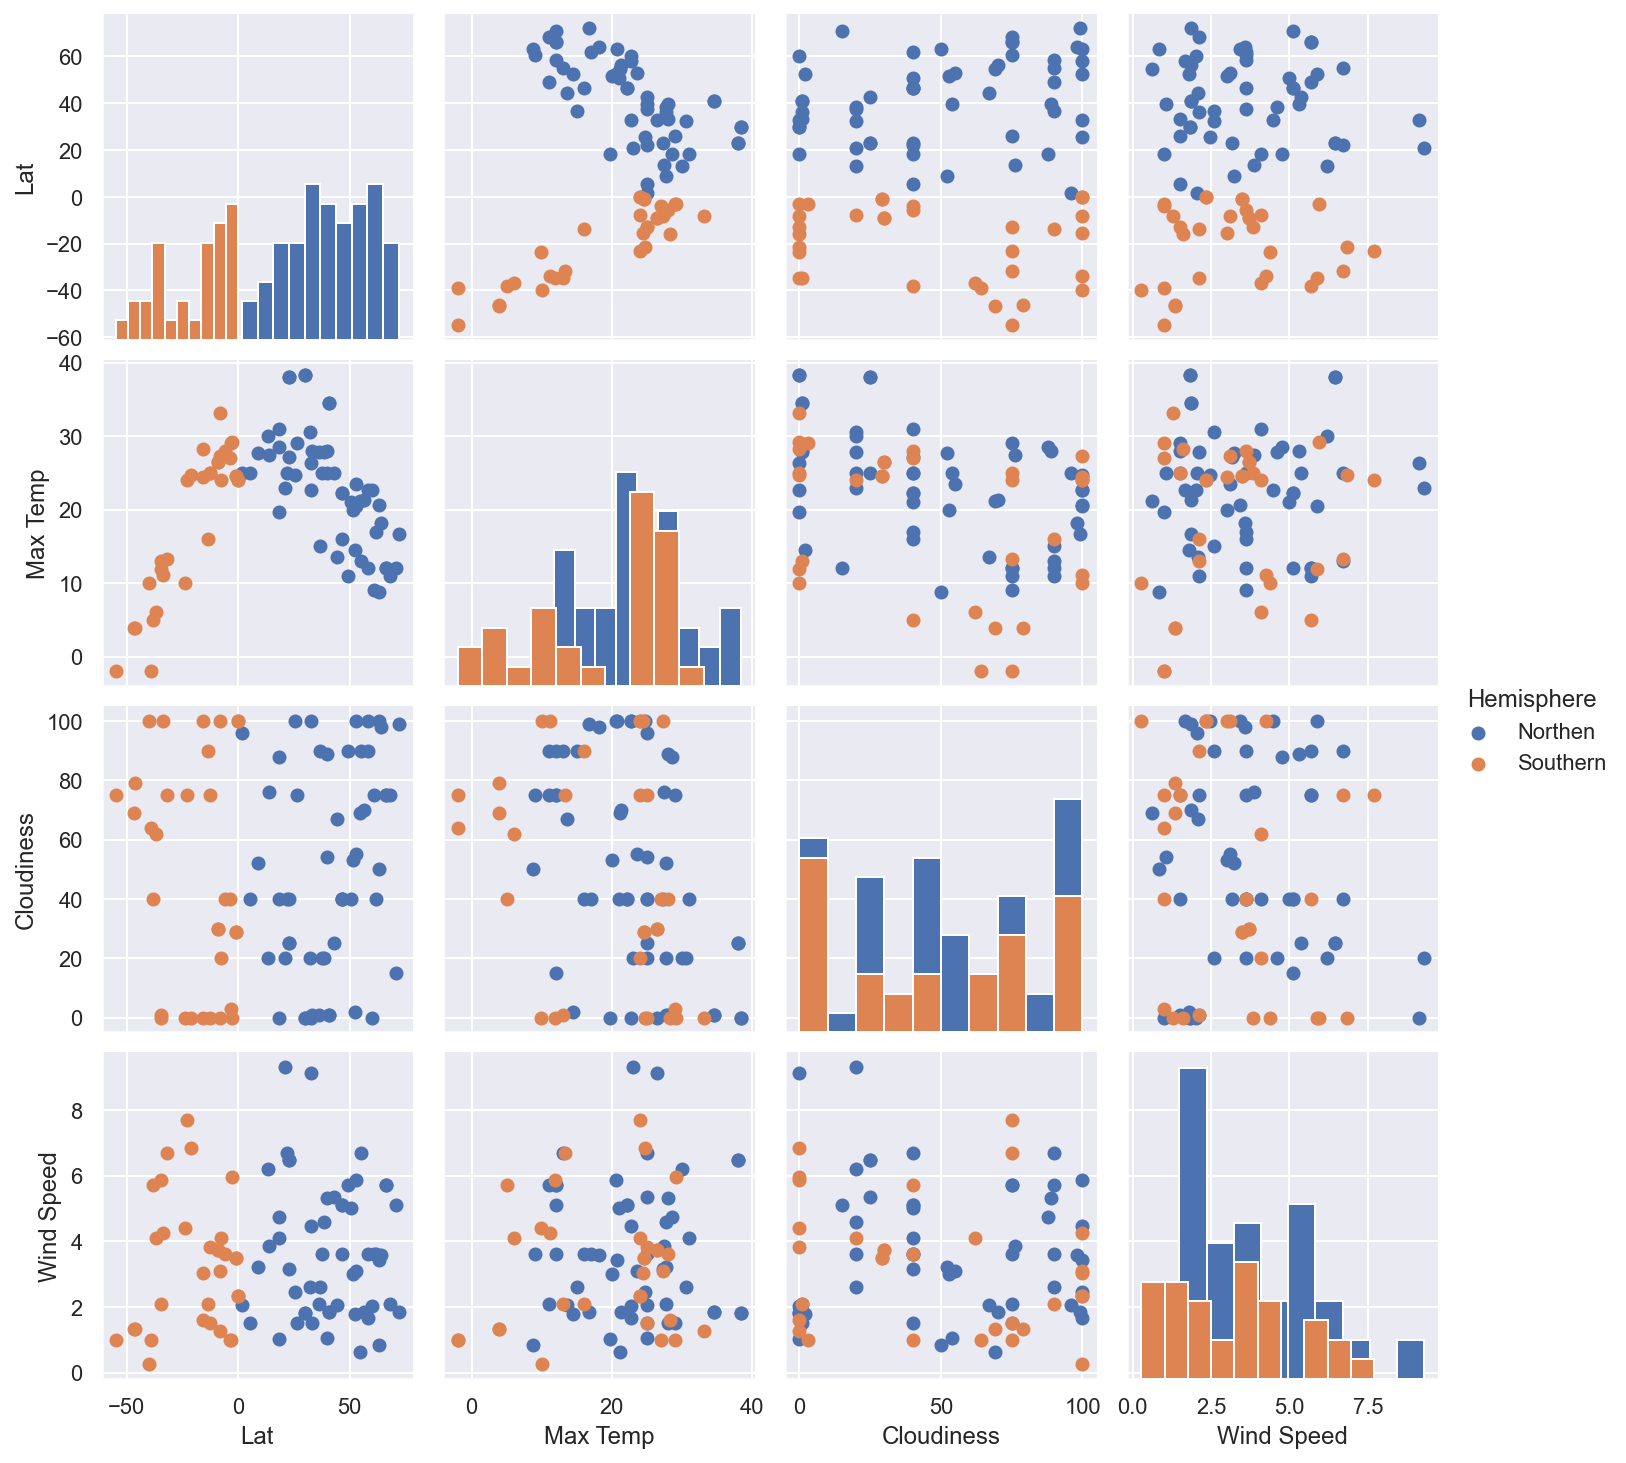

In [84]:
# Create Northern and Southern Hemisphere DataFrames
explore_data = clean_city_data.filter(['Lat', 'Max Temp', 'Cloudiness', 'Wind Speed', 'Hemisphere'])
g=sns.PairGrid(explore_data, hue='Hemisphere')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()
print(' '*23,'Data exploration (Northern vs Southern Hemisphere)')

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression